In [1]:
# Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

In [63]:
#      Constants and general model setup
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
p_ice = 917
cp_w = 4180            # specific heat capacity [J/(kg*K)]
cp_ice = 2100
k_w = 0.56*toyr        # thermal conductivity [(J/yr)/(m K)]
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

p_w = 1000
cp_w = 4180
k_w = 0.56 * toyr

#Julie paper

#p_ice = 917
#cp_ice = 185 + 7.037*T
#k_ice = (0.4685 + (488.12/T)) * toyr
#L=333.6*1000  

#clathrate hydrates
p_hyd = 1000
cp_hyd = 494 + (6.1*150)
k_hyd = 0.64 * toyr

#hydrated salt
p_salt = 2200
cp_salt = 920
k_salt = 0.6 * toyr

#silicate rock
p_rock = 2430
cp_rock = 2000
k_rock = 0.56 * toyr


            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=0                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.5, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##
nIce = [0, 0.2, 0.4] # Lee et al. 2005


                    ### Material 1 - Lobate
#start with 40% ice, 25% hydrates, 20% rock, 15% salts
nL = nLob[n_Sc]   
nI = nIce[n_Sc]
p_soilL = 1300       ## DENSITY (thermal model; 2B)             
cp_soilL = 1538.46       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with temperature dependence)    
k_soilL = 1.27*toyr   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (20% ice, 45% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]
pcp = [2e6, 14e6, 4e6] #average effective heat capacity for 150<T<245, 245<T<273, and 273<T<300 K, respectively


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
print(nocell)

301


In [64]:
 ### Temperature ###
Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini_1=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(len(T_ini_1)):
    if 0 <= i < 2:
        T_ini_1[i] = 150.00
    elif 2 <= i < (nocell-1)/2:
        T_ini_1[i] = (((300-150)/(grid_depth/2))*z[i]) + 150
    elif i == (nocell-1)/2:
        T_ini_1[i] = 300
    elif i > (nocell-1)/2:
        T_ini_1[i] = (((150-300)/(grid_depth/2))*z[i-150]) + 300
    elif i == grid_depth-1:
        T_ini_1[i] = 150.00
    #else:
    #    T_ini_1[i] = 300.00

T_ini = [round(item, 2) for item in T_ini_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
print(T_ini)

[150.0, 150.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 235.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 244.0, 245.0, 246.0, 247.0, 248.0, 249.0, 250.0, 251.0, 252.0, 253.0, 254.0, 255.0, 256.0, 257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 287.0, 288.0, 289.0, 290.0, 291.0, 292.0

In [65]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file
TCurve_data = pd.read_csv('cerestempcurve.txt', header=None)

T_ann10 = TCurve_data[1] #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step

print(T_ann10q[-1])

150.0


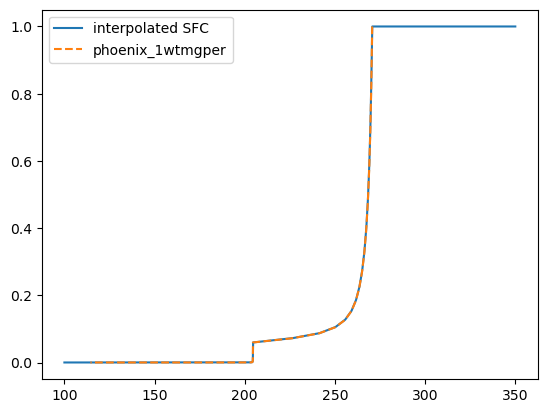

In [66]:
# reading in SFC, creating interpolated pore water fractions from input temp array and SFC

phoenix_1wtmgper = pd.read_csv('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/SFCs/phoenix_1wtmgper.txt', header=None)
fw4 = phoenix_1wtmgper[1] #liquid fraction in the pore space, Sl = 1- Si, dep variable
temp4 = -1*phoenix_1wtmgper[0] #degrees celsius, indep variable
temp4 = temp4 + 273.15 #converted temperatures to Kelvin

interp_temps = np.arange(100, 350, 0.01)
interp_fw = interp1d(temp4, fw4, kind='linear', fill_value='extrapolate')
SFC_fw = interp_fw(interp_temps)

for i in range(len(SFC_fw)): #manually set fw at 1 for all cells above freezing
    if SFC_fw[i] >= 1:
        SFC_fw[i] = 1
        
plt.plot(interp_temps, SFC_fw, label='interpolated SFC')
plt.plot(temp4, fw4, label='phoenix_1wtmgper', linestyle='dashed')
#plt.ylim(-0.1,1.1)
plt.legend()

In [75]:
# Function to get fw for an input temperature

def get_fw(temp):
    indices = np.where(np.isclose(interp_temps, temp, atol=0.1))[0] #gets index for initial temp value in interp_temp
    index = indices[0] #in case there are multiple indices
    f_w_value = SFC_fw[index]
    return(f_w_value)

In [76]:
### Assigning material IDs to the different model grids and creating empty vectors and matrices. ###

# 1=Lobate 2=Boulders 3=Ice
onegrid=np.ones(nocell) # 1 x 301 matrix

                # Material IDs ZONEs
Z0_1MatID=np.ones(nocell)
Z0_1MatID[0]=3
Z0_1MatID[1]=3
Z0_1MatID[291:]=2 #boulders (bottom 20m)

Z1_2MatID=np.ones(nocell)
Z1_2MatID[0]=3
Z1_2MatID[1]=3
Z1_2MatID[251:]=2 #boulders (bottom 100m)

            ### Creating one-vectors and empty matrices used in for-loop ###
#n_grid=np.ones(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
#p_soil=np.ones(nocell)
#cp_soil=np.ones(nocell)
#k_soil=np.ones(nocell)

#df_w=np.zeros(nocell-1) ## CHANGE IN fraction of water in pore space
#k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
#C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
#a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 500

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
T_matx_0_1[:,0] = np.copy(T_ini)                                    ### add more as needed
T_matx_1_2=np.zeros((nocell,runtime))
T_matx_1_2[:,0] = np.copy(T_ini)

w=0.957725     # Correction factor, DESCRIBED IN SECTION 4.1 IN PAPER, T_S = -2 ºC, T_L = 0 ºC

In [77]:
# Assign initial F_w, F_ice, f_w, and f_ice values for the model domain given the initial temperature.
# I want to match the initial temperature to whatever index it is in interp_temps, grab the value of
# that same index in SFC_fw, and set that value as the initial f_w

#for this to work, needs to be the last cell before model begins (i.e., all material properties must be set before this)

# First, initialize the fraction arrays
F_w = np.zeros(nocell)
F_ice = np.zeros(nocell)
f_w = np.zeros(nocell)
f_ice = np.zeros(nocell)
F_soil = np.zeros(nocell)

# assign values to f_w first, since this is info from SFC
for i in range(len(T_ini)): #len(T_ini) = nocell
    f_w[i] = get_fw(T_ini[i])

#using f_w values, assign initial values of other fraction arrays
for i in range(nocell):
    f_ice[i] = 1 - f_w[i]
    F_w[i] = f_w[i] * n_grid[i]
    F_ice[i] = n_grid[i] - F_w[i]
    F_soil[i] = 1 - n_grid[i]
    
#The top and bottom cells are excluded from model runs, so we need to prescribe fractions to them
f_w[0]=0
f_w[-1]=1
#F_w=onegrid
F_w[0]=0
f_ice[0]=1
f_ice[-1]=0
F_ice[-1]=0

#column-specific ice fraction arrays
f_matx_0_1=np.zeros((nocell,runtime)) #ice fraction
f_matx_0_1[:,0] = np.copy(f_ice)
f_matx_1_2=np.zeros((nocell,runtime))
f_matx_1_2[:,0] = np.copy(f_ice)

In [78]:
### Numerical Model ###
start_time = time.time()

col_incl=[1,2]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
for col in col_incl:
    if col==1:            ### Defining the column in use
        runtime=500      # Simulation runtime
        materialid=np.copy(Z0_1MatID)
    elif col==2:            ### Defining the column in use
        runtime=500      # Simulation runtime
        materialid=np.copy(Z1_2MatID)
    
    n_grid=np.ones(nocell)
    p_soil=np.ones(nocell)
    cp_soil=np.ones(nocell)
    k_soil=np.ones(nocell)
    
    df_w=np.zeros(nocell-1) ## CHANGE IN fraction of water in pore space
    k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
    C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
    a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY
    
    for ii in range(nocell): #applying material properties to each cell in the domain
        if materialid[ii] == 1: #1 = Lobate, mud slurry
            n_grid[ii] = onegrid[ii] * nL
        if materialid[ii] == 1:
            p_soil[ii] = onegrid[ii] * p_soilL
        if materialid[ii] == 1:
            cp_soil[ii] = onegrid[ii] * cp_soilL
        if materialid[ii] == 1:
            k_soil[ii] = onegrid[ii] * k_soilL
        if materialid[ii] == 2: #2 = rock, density = 1585.5 kg/m^3 (boulders)
            n_grid[ii] = onegrid[ii] * nL
        if materialid[ii] == 2: 
            p_soil[ii] = onegrid[ii] * ((0.56*p_hyd)+(0.25*p_rock)+(0.19*p_salt)) #linear combination, not super accurate, just playing around
        if materialid[ii] == 2:
            cp_soil[ii] = onegrid[ii] * ((0.56*cp_hyd)+(0.25*cp_rock)+(0.19*cp_salt))
        if materialid[ii] == 2:
            k_soil[ii] = onegrid[ii] * ((0.56*k_hyd)+(0.25*k_rock)+(0.19*k_salt))
        if materialid[ii] == 3: #3 = ice, carapace
            n_grid[ii] = onegrid[ii] * nI
        if materialid[ii] == 3:
            p_soil[ii] = onegrid[ii] * p_ice
        if materialid[ii] == 3:
            cp_soil[ii] = onegrid[ii] * cp_ice
        if materialid[ii] == 3:
            k_soil[ii] = onegrid[ii] * k_ice

    no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

    T_11 = np.copy(T_ann10q[:no_tstep + 1])  # Cutting temperature curve to simulation period
    T_1 = np.flip(T_11)  # New T_1 #This is just 150 K for each time step
    
    ### stability criterion ###
    # calculates the effective thermal diffusivity of the soil and ice material
    # if stability < 0.5, model will proceed
    k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
    C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
    a_s_ice = k_s_ice / C_s_ice
    stability = (np.max(a_s_ice) * tstep / dz**2)

    #temperature array used in numerical model
    T = np.zeros((nocell, no_tstep))
    T[:, 0] = np.copy(T_ini)
    
    ### heat transfer loop starts
    if col==1:
        xT_ini = np.copy(T_ini)
        k = 0 #time step count
        l = 0 #year count
        for t in range(no_tstep):
            if stability > 0.5:
                break
            k += 1
            for i in range(1, nocell-1): #excluding top and bottom bc they have prescribed fractions
                f_w[i] = get_fw(xT_ini[i])
                f_ice[i] = 1 - f_w[i]

                # df_w/dT
                #not sure how to handle this next block of code with new freezing curve
                if xT_ini[i] < 271.15:
                    df_w[i] = 0
                elif xT_ini[i] > 273.15:
                    df_w[i] = 0
                else:
                    df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # diff of eq. A — leave this for now

                F_w[i] = f_w[i] * n_grid[i]
                F_ice[i] = f_ice[i] * n_grid[i]

                #calculating equivalent material properties
                k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (f_w[i] * np.sqrt(k_w)) + (f_ice[i] * np.sqrt(k_ice))) ** 2
                C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (f_w[i] * p_w * cp_w) + (f_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                a_eq[i] = k_eq[i] / C_eq[i]

                if (xT_ini1[i + 1] - xT_ini1[i - 1]) != 0:
                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                else:
                    T[i, t] = xT_ini[i]

                T[0, t] = T_1[t] #setting the top boundary to 150 K
                T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be

            xT_ini = np.copy(T[:, t])    ### Value used in loop

            a_eq_0_1=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
            C_eq_0_1=np.copy(C_eq)
            f_w_0_1=np.copy(f_w)
            f_ice_0_1=np.copy(f_ice)

             ### Creating a matrix with the temperature distribution for each year
            if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                if l != runtime:
                    ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                    # updates column of T matrix w temps from time step
                    T_matx_0_1[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                    f_matx_0_1[:,l]=np.copy(f_w)
                    l+=1 # INCREASE TO NEXT YEAR
                    k=0
                elif l == runtime:
                    l += 1
                    k = 0

    elif col==2:
        xT_ini = np.copy(T_ini)
        k = 0 #time step count
        l = 0 #year count
        for t in range(no_tstep):
            if stability > 0.5:
                break
            k += 1
            for i in range(1, nocell-1): #excluding top and bottom bc they have prescribed fractions
                f_w[i] = get_fw(xT_ini[i])
                f_ice[i] = 1 - f_w[i]

                # df_w/dT
                #not sure how to handle this next block of code with new freezing curve
                if xT_ini[i] < 271.15:
                    df_w[i] = 0
                elif xT_ini[i] > 273.15:
                    df_w[i] = 0
                else:
                    df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # diff of eq. A — leave this for now

                F_w[i] = f_w[i] * n_grid[i]
                F_ice[i] = f_ice[i] * n_grid[i]

                #calculating equivalent material properties
                k_eq[i] = ((F_soil[i] * np.sqrt(k_soil[i])) + (f_w[i] * np.sqrt(k_w)) + (f_ice[i] * np.sqrt(k_ice))) ** 2
                C_eq[i] = (F_soil[i] * p_soil[i] * cp_soil[i]) + (f_w[i] * p_w * cp_w) + (f_ice[i] * p_ice * (cp_ice + L * df_w[i]))
                a_eq[i] = k_eq[i] / C_eq[i]

                if (xT_ini2[i + 1] - xT_ini2[i - 1]) != 0:
                    T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
                else:
                    T[i, t] = xT_ini[i]

                T[0, t] = T_1[t] #setting the top boundary to 150 K
                T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be

            xT_ini = np.copy(T[:, t])      ### Value used in loop

            a_eq_1_2=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
            C_eq_1_2=np.copy(C_eq)
            f_w_1_2=np.copy(f_w)
            f_ice_1_2=np.copy(f_ice)

             ### Creating a matrix with the temperature distribution for each year
            if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
                if l != runtime:
                    ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                    # updates column of T matrix w temps from time step
                    T_matx_1_2[:,l]=np.copy(T[:,t])     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                    f_matx_1_2[:,l]=np.copy(f_w)
                    l+=1 # INCREASE TO NEXT YEAR
                    k=0
                elif l == runtime:
                    l += 1
                    k = 0

                    
                    
print('complete')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
T.shape #should be nocell x no_tstep

(301, 20000)

In [14]:
T_matx_0_1.shape #should be nocell x runtime

(301, 1000)

In [15]:
f_w.shape

(301,)

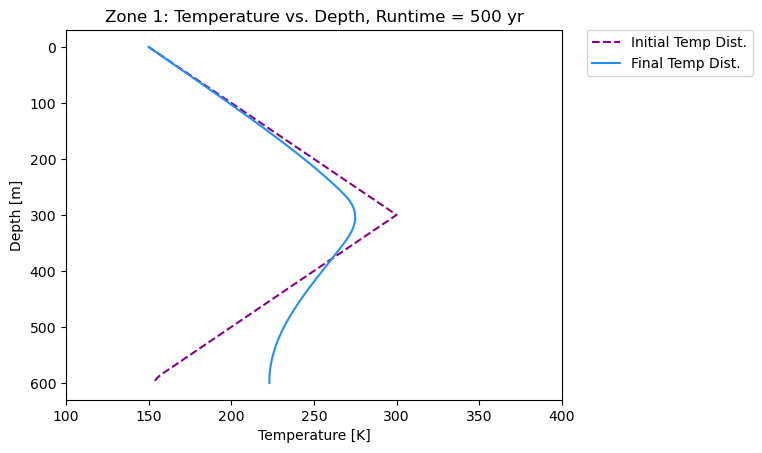

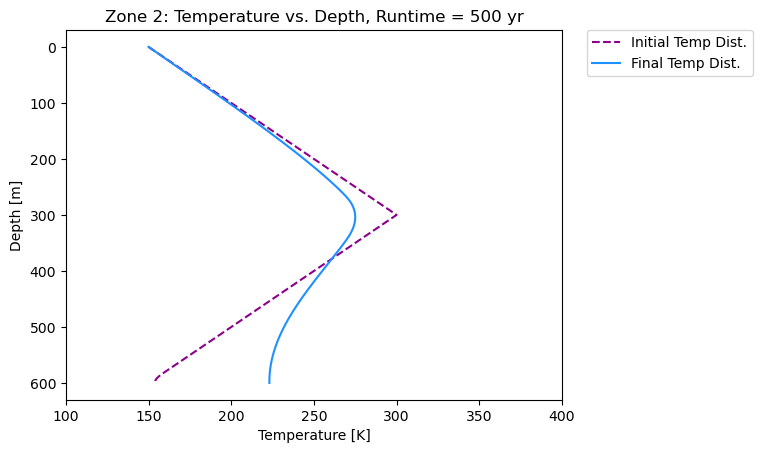

In [40]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.figure()
plt.xlim([100,400])
plt.plot(T_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Temp Dist.')
plt.plot(T_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.figure()
plt.xlim([100,400])
plt.plot(T_matx_1_2[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Temp Dist.')
plt.plot(T_matx_1_2[:,runtime-1], z, color='dodgerblue', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Zone 2: Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [41]:
T_diff = np.zeros(nocell)

for i in range(nocell):
    T_diff[i] = T_matx_0_1[i,-1] - T_matx_1_2[i,-1]
    
print(T_diff)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


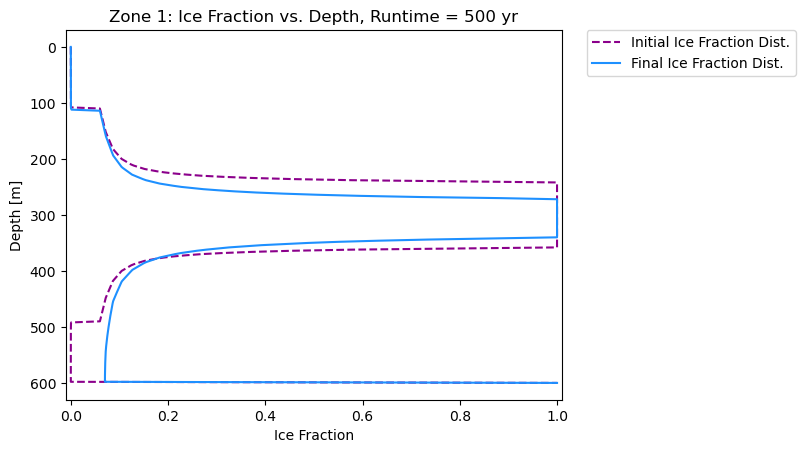

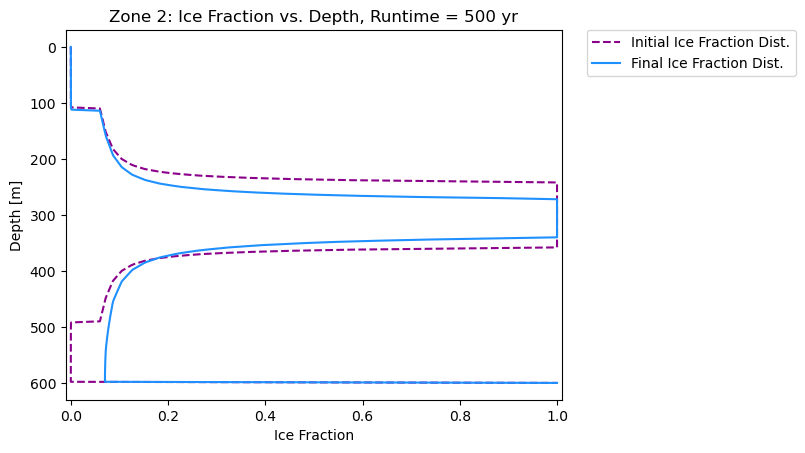

In [42]:
### Fig - Final ice fraction distrubution
#plotting curves for initial and final f_ice distributions

plt.figure()
plt.xlim([-0.01,1.01])
plt.plot(f_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Ice Fraction Dist.')
plt.plot(f_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Ice Fraction Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Ice Fraction')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Ice Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.figure()
plt.xlim([-0.01,1.01])
plt.plot(f_matx_1_2[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Ice Fraction Dist.')
plt.plot(f_matx_1_2[:,runtime-1], z, color='dodgerblue', label='Final Ice Fraction Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Ice Fraction')
plt.ylabel('Depth [m]')
plt.title('Zone 2: Ice Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

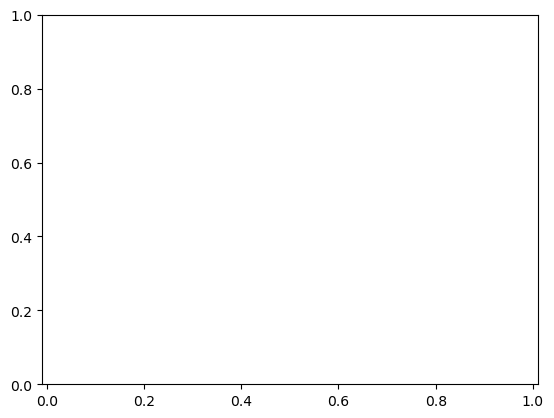

In [19]:
plt.xlim([-0.01,1.01])
plt.plot(f_w[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Liquid Fraction Dist.')
plt.plot(f_w[:,runtime-1], z, color='dodgerblue', label='Final Liquid Fraction Dist.')
plt.plot(f_ice[:,0], z, linestyle='dashed',color='firebrick', label='Initial Ice Fraction Dist.')
plt.plot(f_ice[:,runtime-1], z, color='darkorange', label='Final Ice Fraction Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Ice Fraction')
plt.ylabel('Depth [m]')
plt.title('Ice Fraction vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
# when runtime is 100,000 yr, code takes ~2 hr to run

## Aggradation rate and depth of PF & FF

In [43]:
TqFF= 271.15 #K, freezing front temp
Tq_1= 272.15 #not sure what this is
TqPF= 273.15 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

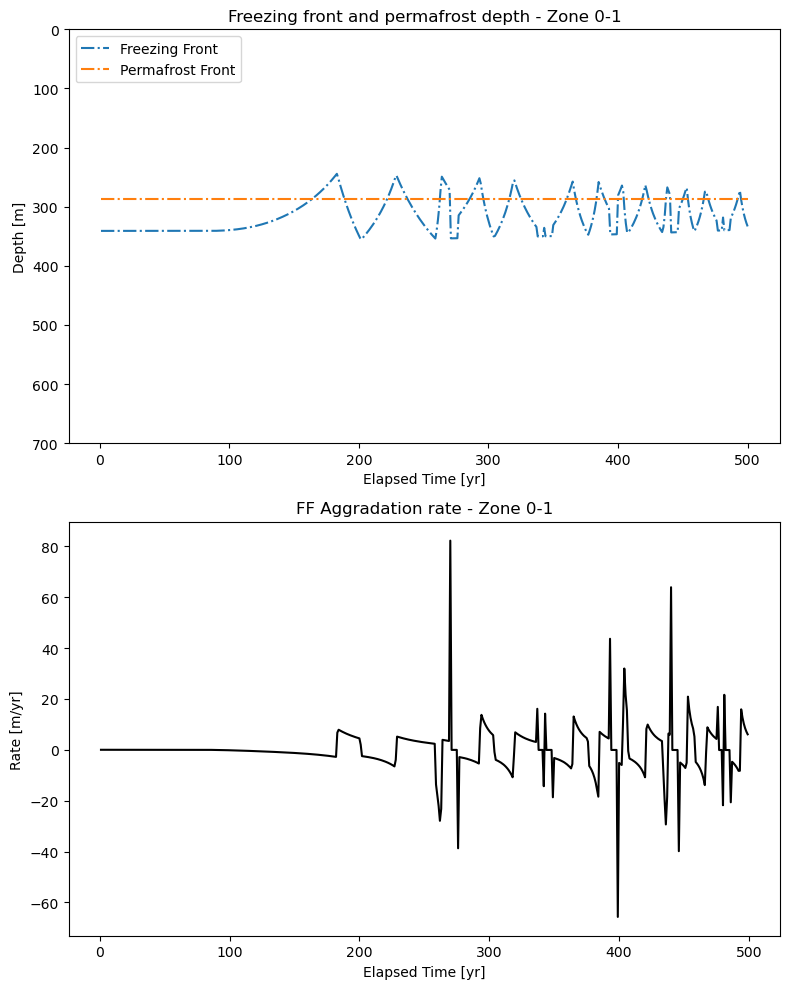

In [44]:
colcount = 1

for col in col_incl:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value
            tt[i] = t_intv * k

        colcount += 1
        presentFFdepth[colcount]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
print(zqFF)

In [ ]:
print(zqPF)

## Final PF and FF depths

In [ ]:
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

## Final Aggradation Rate and Recharge Equivalent

In [ ]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 

## Plotting Final Effective Material Properties 

In [22]:
print(a_eq_0_1)

[ 0.         36.67409623 36.67407308 36.67404966 36.67402652 36.67400309
 36.67397966 36.67395652 36.6739331  36.67390996 36.67388653 36.67386339
 36.67384025 36.67381682 36.67379368 36.67377054 36.6737474  36.67372426
 36.67370112 36.67367798 36.67365512 36.67363198 36.67360884 36.67358598
 36.67356313 36.67354027 36.67351742 36.67349456 36.67339157 36.67326656
 36.67313998 36.67301498 36.67288998 36.67276498 36.67263998 36.67251498
 36.67239156 36.67226814 36.67214473 36.67202131 36.6718979  36.67177606
 36.67165265 36.67153082 36.67132141 36.67108906 36.67085672 36.67062133
 36.67039205 36.67015971 36.66993043 36.6696981  36.66947188 36.66924261
 36.6689185  36.66844486 36.66797122 36.6674976  36.66703038 36.66656316
 36.6659997  36.66510071 36.66421406 36.66333974 36.66216356 36.66035174
 36.65856555 36.65560917 36.65109184 36.6409874  36.56498771 32.2593994
 32.23228601 32.20559113 32.17892161 32.15266906 32.12644105 32.10062849
 32.07483968 32.04907461 32.0237231  31.99878404 31.

In [23]:
print(C_eq_0_1)

[      0.         1925954.86121672 1925955.51655764 1925956.17998919
 1925956.83533011 1925957.49876166 1925958.16219321 1925958.81753413
 1925959.48096567 1925960.13630659 1925960.79973814 1925961.45507906
 1925962.11041998 1925962.77385153 1925963.42919245 1925964.08453337
 1925964.73987429 1925965.3952152  1925966.05055612 1925966.70589704
 1925967.35314733 1925968.00848825 1925968.66382917 1925969.31107946
 1925969.95832975 1925970.60558004 1925971.25283033 1925971.90008063
 1925974.81696445 1925978.35705796 1925981.94196278 1925985.48205629
 1925989.0221498  1925992.56224331 1925996.10233682 1925999.64243033
 1926003.13771253 1926006.63299473 1926010.12827693 1926013.62355913
 1926017.11884133 1926020.56931222 1926024.06459442 1926027.51506531
 1926033.4460321  1926040.02645511 1926046.60687813 1926053.27388566
 1926059.76772416 1926066.34814717 1926072.84198568 1926079.42240869
 1926085.82966268 1926092.32350118 1926101.50372105 1926114.91931845
 1926128.33491584 1926141.75051324

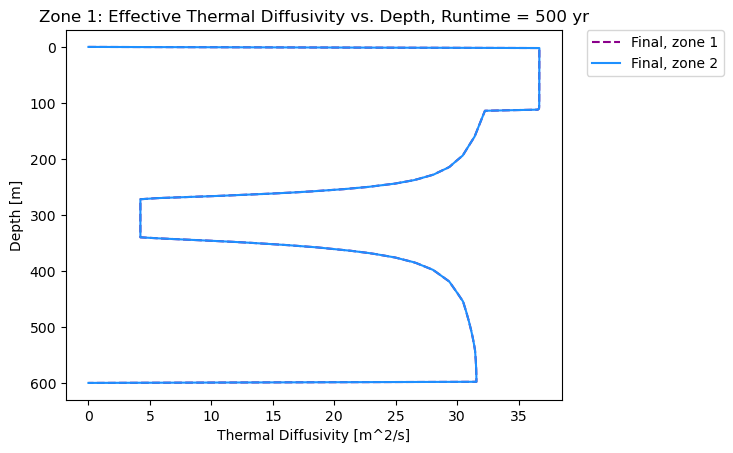

In [45]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective thermal diffusivity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(a_eq_0_1, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
plt.plot(a_eq_1_2, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Thermal Diffusivity [m^2/s]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Thermal Diffusivity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


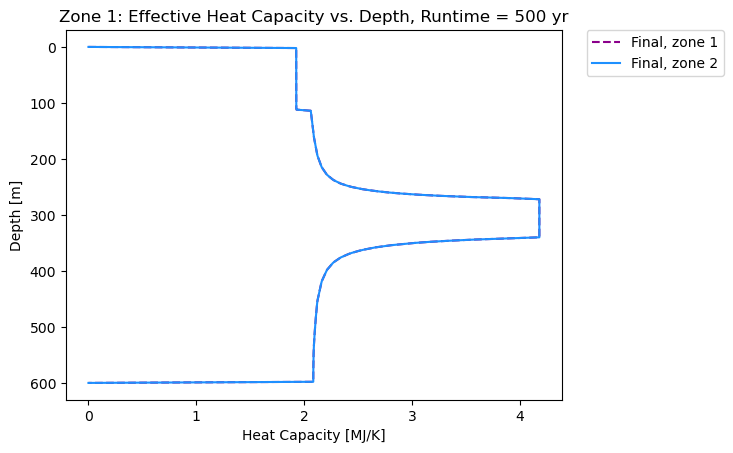

In [46]:
### Fig - Final effective material property distrubutions
#plotting curves for initial and final effective heat capacity distributions

plt.figure()
#plt.xlim([100,400])
plt.plot(C_eq_0_1/1e6, z, linestyle='dashed',color='darkmagenta', label='Final, zone 1')
plt.plot(C_eq_1_2/1e6, z, color='dodgerblue', label='Final, zone 2')
plt.gca().invert_yaxis()
plt.xlabel('Heat Capacity [MJ/K]')
plt.ylabel('Depth [m]')
plt.title('Zone 1: Effective Heat Capacity vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [27]:
np.shape(a_eq_0_1)

(301,)